In [1]:
import pickle
import PIL, torch, torchvision
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from torchvision import models
from torch import nn
import pandas as pd

from load_data import load_et_maps, load_images, load_labels, classes
from load_models import load_mobilenet, load_resnet
from utils import batch_accuracy, get_targets

device = torch.device("cuda")

dtype = torch.float32

OCC_ONLY = Path('/home/florian/dev/ET-Adversarials/data/Occ_only_226px/')
IMGS = Path('/home/florian/dev/ET-Adversarials/data/scaled_images/')
GRADCAM_HM = Path('/home/florian/dev/ET-Adversarials/data/gradcam_heatmaps.pkl')

# Load Data and Model

Mind that the non-adversarially trained model has an normalization layer, while the adversarially trained model does not have the normalization layer. Thus we need to adapt the image loading and foolbox models depending on whicht model is used.

In [2]:
#img_batch = load_images(IMGS, normalize=True).to(device)
img_batch = load_images(IMGS, normalize=False).to(device)
etm_batch = load_et_maps(OCC_ONLY).to(device)
labels = load_labels(IMGS).to(device)
gradcam_heatmaps = torch.load(GRADCAM_HM).to(device)

In [3]:
MOBILENET_PATH = './models/MobileNetV3Small.pt'
model = load_mobilenet(MOBILENET_PATH).to(device)
batch_accuracy(model, img_batch, labels)

1.0

In [4]:
MOBILENET_PATH = './models/MobileNetV3Small-adversarially-trained.pt'
model = load_mobilenet(MOBILENET_PATH, norm_layer=True).to(device)
batch_accuracy(model, img_batch, labels)

0.97

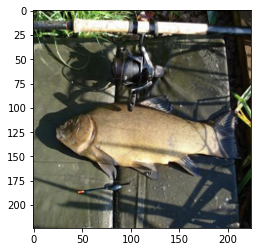

In [5]:
plt.imshow(img_batch[6].cpu().detach().permute(1,2,0))

# Attack

In [6]:
targets = get_targets(model, img_batch.to(device), labels)

In [7]:
import foolbox
from foolbox.attacks import L2CarliniWagnerAttack_W_ET, L2CarliniWagnerAttack, PGD, L2BrendelBethgeAttack
from foolbox.criteria import TargetedMisclassification

##### Teting early Stopping

In [8]:

#img_batch.requires_grad_(False)
model.eval()
fmodel = foolbox.PyTorchModel(
    model.to(device), 
    bounds=(img_batch.min(),img_batch.max()), 
    #preprocessing=dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
)
foolbox_advs = torch.empty((0,3,224,224)).cuda()


attack = L2CarliniWagnerAttack(eps_early_stop=True, steps=100, binary_search_steps=1)
raw_advs, clipped_advs, success = attack(
    fmodel, 
    img_batch.to(device)[6:11],
    labels[6:11].long().to(device), 
    epsilons=[1],
)

<class 'eagerpy.tensor.pytorch.PyTorchTensor'>
<class 'eagerpy.tensor.pytorch.PyTorchTensor'> <class 'eagerpy.tensor.pytorch.PyTorchTensor'>
<class 'eagerpy.tensor.pytorch.PyTorchTensor'> <class 'eagerpy.tensor.pytorch.PyTorchTensor'>
<class 'eagerpy.tensor.pytorch.PyTorchTensor'> <class 'eagerpy.tensor.pytorch.PyTorchTensor'>
<class 'eagerpy.tensor.pytorch.PyTorchTensor'> <class 'eagerpy.tensor.pytorch.PyTorchTensor'>
<class 'eagerpy.tensor.pytorch.PyTorchTensor'> <class 'eagerpy.tensor.pytorch.PyTorchTensor'>
<class 'eagerpy.tensor.pytorch.PyTorchTensor'> <class 'eagerpy.tensor.pytorch.PyTorchTensor'>
<class 'eagerpy.tensor.pytorch.PyTorchTensor'> <class 'eagerpy.tensor.pytorch.PyTorchTensor'>
<class 'eagerpy.tensor.pytorch.PyTorchTensor'> <class 'eagerpy.tensor.pytorch.PyTorchTensor'>
<class 'eagerpy.tensor.pytorch.PyTorchTensor'> <class 'eagerpy.tensor.pytorch.PyTorchTensor'>
<class 'eagerpy.tensor.pytorch.PyTorchTensor'> <class 'eagerpy.tensor.pytorch.PyTorchTensor'>


In [11]:

#img_batch.requires_grad_(False)
model.eval()
fmodel = foolbox.PyTorchModel(
    model.to(device), 
    bounds=(img_batch.min(),img_batch.max()), 
    #preprocessing=dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
)
foolbox_advs = torch.empty((0,3,224,224)).cuda()


attack = L2BrendelBethgeAttack()#eps_early_stop=True,)
raw_advs, clipped_advs, success = attack(
    fmodel, 
    img_batch.to(device)[6:11],
    labels[6:11].long().to(device), 
#    epsilons = [1]
)

TypeError: __call__() missing 1 required keyword-only argument: 'epsilons'

In [12]:
!pip list

Package                 Version         Location
----------------------- --------------- ----------------------------
absl-py                 1.0.0
aiohttp                 3.8.1
aiosignal               1.2.0
argon2-cffi             21.1.0
async-timeout           4.0.1
attrs                   21.2.0
backcall                0.2.0
bleach                  4.1.0
bokeh                   2.4.2
cachetools              4.2.4
certifi                 2021.5.30
cffi                    1.14.6
charset-normalizer      2.0.6
cleverhans              4.0.0           /home/florian/dev/cleverhans
click                   8.0.3
cloudpickle             2.0.0
configparser            5.2.0
cycler                  0.10.0
debugpy                 1.4.3
decorator               5.1.0
defusedxml              0.7.1
dm-tree                 0.1.6
docker-pycreds          0.4.0
eagerpy                 0.29.0
easydict                1.9
efficientnet-pytorch    0.7.1
entrypoints             0.3
foolbox                 3.3.

In [ ]:
# with eps-early-stopping=True
(raw_advs[0]-img_batch[6:11]).norm(dim=(2,3)).norm(dim=(1))

In [ ]:
# with eps-early-stopping=False
(raw_advs[0]-img_batch[6:11]).norm(dim=(2,3)).norm(dim=(1))

In [ ]:
assert True==False

In [ ]:
import eagerpy as ep

In [ ]:
ep.astensor(np.ones(5))

##### Standard Carlini&Wagner L2

In [ ]:
attack = L2CarliniWagnerAttack()
img_batch.requires_grad_(False)
model.eval()
fmodel = foolbox.PyTorchModel(
    model.to(device), 
    bounds=(img_batch.min(),img_batch.max()), 
    #preprocessing=dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
)
foolbox_advs = torch.empty((0,3,224,224)).cuda()
BS = 50
for b in [50,100]:
    raw_advs, clipped_advs, success = attack(
        fmodel, 
        img_batch.to(device)[b-BS:b],
        labels[b-BS:b].long().to(device), 
        epsilons=[10],
    )

    foolbox_advs = torch.cat((foolbox_advs,raw_advs[0]))

    print(success.sum()/BS)
with open('./adversarial_examples/adv-trained-foolbox-cw-l2-targeted-advs.pkl', 'wb') as handle:
#with open('./adversarial_examples/foolbox-cw-l2-targeted-advs.pkl', 'wb') as handle:
    pickle.dump(foolbox_advs, handle, protocol=pickle.HIGHEST_PROTOCOL)    
    
    

##### Adapated Carlini&Wagner with Eye Tracking Data

In [ ]:
attack = L2CarliniWagnerAttack_W_ET()

img_batch.requires_grad_(False)
model.eval()
fmodel = foolbox.PyTorchModel(
    model.to(device), 
    bounds=(img_batch.min(),img_batch.max()), 
#    preprocessing=dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
)

foolbox_et_advs = torch.empty((0,3,224,224)).cuda()
BS = 50
for b in [50,100]:
    et_raw_advs, et_clipped_advs, et_success = attack(
        fmodel, 
        img_batch.to(device)[b-BS:b],
        TargetedMisclassification(targets[b-BS:b].long().to(device)),
        #labels[b-BS:b].long().to(device), 
        et=etm_batch[b-BS:b],
        epsilons=[10],
        et_loss_consts=[1,.1]
    )

    foolbox_et_advs = torch.cat((foolbox_et_advs,et_raw_advs[0]))
    print(et_success.sum()/BS)
with open('./adversarial_examples/adv-trained-foolbox-et-adapted-cw-l2-targeted-advs.pkl', 'wb') as handle:
#with open('./adversarial_examples/foolbox-et-adapted-cw-l2-targeted-advs.pkl', 'wb') as handle:
    pickle.dump(foolbox_et_advs, handle, protocol=pickle.HIGHEST_PROTOCOL)    

##### Adapated Carlini&Wagner with GradCam Heatmaps

In [ ]:
attack = L2CarliniWagnerAttack_W_ET()

img_batch.requires_grad_(False)
model.eval()
fmodel = foolbox.PyTorchModel(
    model.to(device), 
    bounds=(img_batch.min(),img_batch.max()), 
    #preprocessing=dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
)

foolbox_gc_advs = torch.empty((0,3,224,224)).cuda()
BS = 50
for b in [50,100]:
    gc_raw_advs, gc_clipped_advs, gc_success = attack(
        fmodel, 
        img_batch.to(device)[b-BS:b],
        TargetedMisclassification(targets[b-BS:b].long().to(device)),
        #labels[b-BS:b].long().to(device), 
        et=gradcam_heatmaps[b-BS:b],
        epsilons=[10],
        et_loss_consts=[1,.1]
    )

    foolbox_gc_advs = torch.cat((foolbox_gc_advs,gc_raw_advs[0]))
    print(gc_success.sum()/BS)
with open('./adversarial_examples/adv-trained-foolbox-gradcam-adapted-cw-l2-targeted-advs.pkl', 'wb') as handle:
#with open('./adversarial_examples/foolbox-gradcam-adapted-cw-l2-targeted-advs.pkl', 'wb') as handle:    
    pickle.dump(foolbox_gc_advs, handle, protocol=pickle.HIGHEST_PROTOCOL)    

In [ ]:
def calculate_avg_l2_dist(imgs, advs):
    return (advs.flatten(1)-imgs.flatten(1)).norm(dim=-1).sum()/len(imgs)